In [1]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill



# bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
# versions = ["hess1","hess1u"]
# paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# # mplets = scani.Multiplets(paths[0])
# # mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
# mplet_list = [scani.Multiplets(path) for path in paths]


# unicorns = [9,18]
# for j in unicorns:
#     mplet_list[j].objectifyColumns()

    
# mplets = mplet_list[0]
# mplets.appendMultiplets(*mplet_list[1:])
with open("pkl_jugs/n4/mplets_with_tevcat.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5
print(type(mplets))

<class '__main__.Multiplets'>


In [ ]:
pks2155_mask = mplets.table["TEVCAT_SOURCE_NAME"] == "PKS 2155-304"
mkr421_mask = mplets.table["TEVCAT_SOURCE_NAME"] == "Markarian 421"
mplets.table[mkr421_mask * ~nosource_mask]
# g = vis.hist(mplets.table[mkr421_mask * ~nosource_mask]["Nmax"],histtype="step")
# plt.yscale("log")

Cornerplot of the resulting multiplets

In [ ]:
def get_leftover(redu) -> np.ndarray:

# pval_0_mask = redu["LAMBDA_RATIO_SIGNIFICANCE"]==0.
    bernP_nan_mask = np.isnan(redu["BERNOULLI_P"])
    expP_nan_mask = np.isnan(redu["EXP_CORRECTED_P"])
    bernP_finite_mask = np.isfinite(redu["BERNOULLI_P"])
    expP_finite_mask = np.isfinite(redu["EXP_CORRECTED_P"])
    bernP_0_mask = redu["BERNOULLI_P"] == 0
    expP_0_mask = redu["EXP_CORRECTED_P"] == 0

    sanebern = ~bernP_nan_mask * bernP_finite_mask * ~bernP_0_mask
    saneexp = ~expP_nan_mask * expP_finite_mask * ~expP_0_mask

    leftover = sanebern * saneexp
    return leftover

In [ ]:
# plotting mplet results
from corner import corner, hist2d
from matplotlib import figure

# fig: figure.Figure = corner(mplets[get_leftover(mplets)].to_pandas(),var_names=["dt","da","BERNOULLI_SIGMA"])#, labels=[r"$\mathrm{d}t$ [ns]", r"$\mathrm{d}a$  [deg]"])
# fig: figure.Figure = corner(mplets.to_pandas(),var_names=["dt","da"], labels=[r"$\mathrm{d}t$ [ns]", r"$\mathrm{d}a$  [deg]"])
fig = figure.Figure(figsize=(5,3))
ax = fig.add_subplot()
hist2d(mplets.table["dt"]/1e9,mplets.table["da"],ax=ax,new_fig=False,bins=20)
       
labels=[r"$\mathrm{d}t$ [s]", r"$\mathrm{d}a$  [deg]"]
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_xlim(0,3)
ax.set_ylim(0,0.3)
for ax in fig.get_axes():
    for spine in ["right","top"]:
        ax.spines[spine].set_visible(True)
ax.text(0.3,0.09,"Countour lines shown:\n0.5, 1, 1.5 and 2$\sigma$",horizontalalignment="left",verticalalignment="top")
fig.savefig("figures/dt_da_2dhist.png",facecolor="white")
# fig.savefig("figures/combined/n3_corner_dt_da.png",facecolor="white",dpi=300)

In [ ]:
max(mplets.table["Nmax"])

In [ ]:
from scipy.spatial import KDTree

In [ ]:
t = KDTree([[1,2],[3,4]])

In [ ]:
with open("pkl_jugs/n4/mplets_with_tevcat.pkl", "rb") as f:
    mplets_sorted = dill.load(f)
mplets_sorted.table.sort("Nmax")
A = mplets_sorted.table["TEVCAT_SOURCE_TYPE","TEVCAT_SOURCE_NAME"][::-1][:100]
from pprint import pprint
pprint(np.unique(A).tolist())

TeVCat distance histogram (keep!)

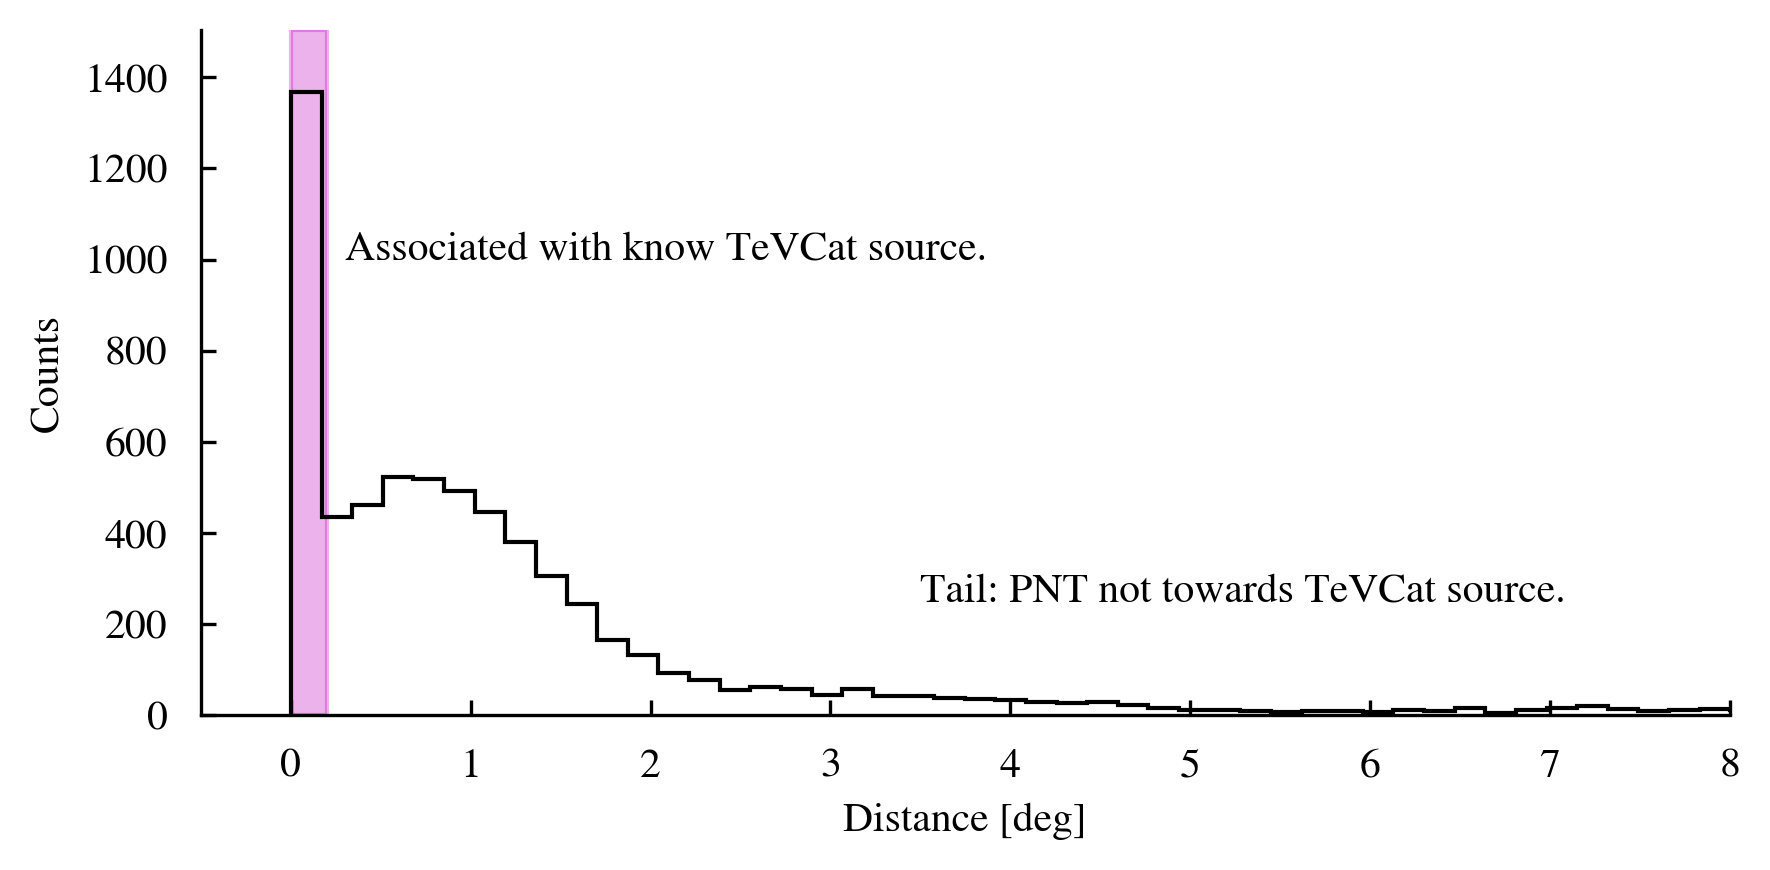

In [5]:
# current_mask = nosource_mask
from matplotlib.figure import Axes

vline_sourcebound = .2
plt.figure(figsize=(6,3))
hist = vis.hist(mplets.table["TEVCAT_DISTANCES_DEG"],bins="freedman",histtype="step",stacked=True)
ax: Axes = plt.gca()
# ax.set_title("Multiplet distance to nearest TeVCat source.",loc="left")
ax.set_xlabel("Distance [deg]")
ax.set_ylabel("Counts")
ylim = ax.get_ylim()
# ax.vlines(vline_sourcebound,0,ylim[1],color="red",ls="--",label=f"{vline_sourcebound} deg")
# ax.set_yscale("log")
ax.set_xlim(-.5,8)
ax.fill_between([0,vline_sourcebound],*ylim, alpha=0.3, color="m",label="Associated with TeVCat source.")
ax.text(.3, 1e3, "Associated with know TeVCat source.")
# ax.text(2, 2650 + 50, "Associated with know TeVCat source.")
ax.arrow(1.9,2675 + 50,-1.5,0, lw=0.5)

# ax.fill_between([5,20],ylim[0],ylim[1]/5,color="green",alpha=0.3)
ax.text(3.5,25e1,"Tail: PNT not towards TeVCat source.")
ax.set_ylim(*ylim)
# ax.legend()
# ax.set_xscale("log")
plt.savefig("figures/n4_sourcedist_hist_makeup.png",facecolor="white",dpi=300)

HEALPix

In [4]:
fig,ax = scani.main_aitov(mplets)
fig.savefig("figures/aitov.png",facecolor="white",dpi=300)

In [ ]:
fig = plt.figure(dpi=300)

Nmax_mask = mplets.table["Nmax"] >= 4
dt_mask = mplets.table["dt"] <= 1e9
current_mask = nosource_mask*Nmax_mask*dt_mask

cmap = cm.jet
cmap.set_bad("r")
NSIDE = 2**5
m = scani.cat2hpx(mplets.table[current_mask]["MEDIAN_RA"],mplets.table[current_mask]["MEDIAN_DEC"],nside=NSIDE)
print(np.sqrt(hp.nside2pixarea(NSIDE,degrees=True)))
mmin, mmax = min(m),max(m)

hp.mollview(m,cmap=cmap, hold=True,nest=False,min=mmin,max=mmax,notext=True,fig=1,cbar=False,title="Transient tool applied on all H.E.S.S. data.")
#create a colorbar axis
cax = fig.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
# cmap.set_under("white")
# axs = fig.get_axes()
# axs[0].images[0].set_norm(colors.SymLogNorm(100))
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')
cb.set_label("Counts")
cb.solids.set_edgecolor("face")

plt.show()
# plt.savefig("figures/combined/healpy.png",facecolor="white")

Nmax histogram

Nmax left after mask: 6


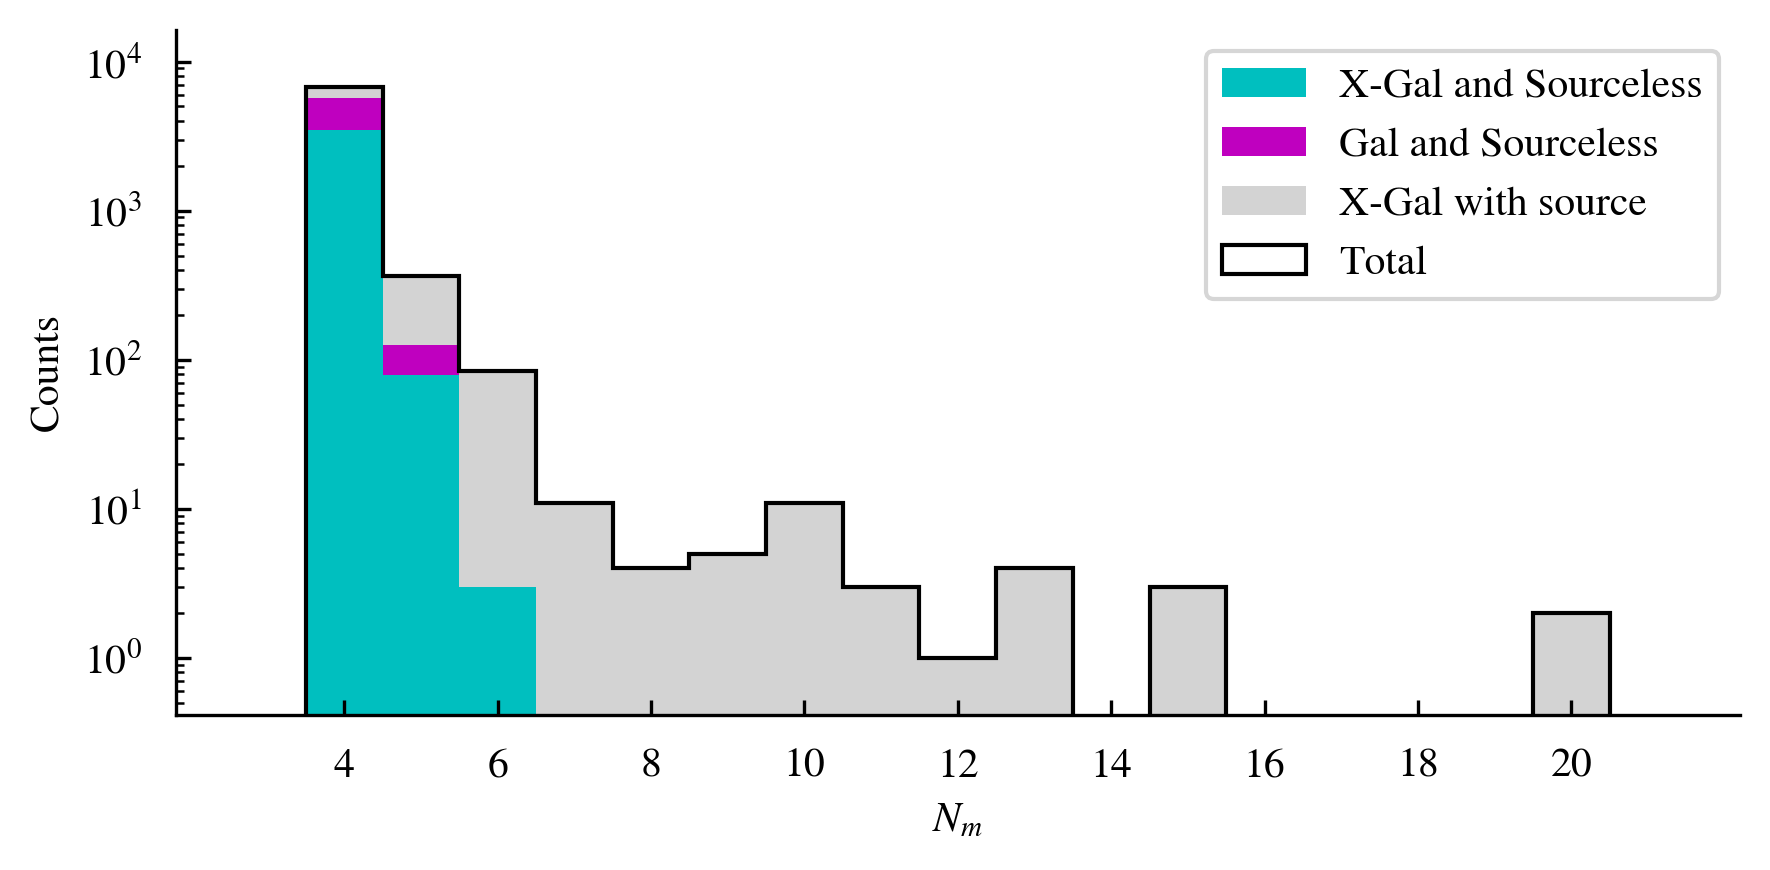

In [11]:
totalmask = nosource_mask * xgal_mask
nos = nosource_mask * ~xgal_mask
xgal = ~nosource_mask * xgal_mask


remaining_Nmax = max(mplets.table[totalmask]["Nmax"])
print(f"Nmax left after mask: {remaining_Nmax}")
nmax_data = mplets.table["Nmax"]
plt.figure(figsize=(6,3))
n,bins,_ = plt.hist([nmax_data[totalmask],nmax_data[nos],nmax_data[xgal]],bins=range(4,22),histtype="bar",stacked=True,color=["c","m","lightgrey"],label=["X-Gal and Sourceless","Gal and Sourceless","X-Gal with source"],align="left")
plt.hist(nmax_data,color="black",histtype="step",bins=bins,label="Total",align="left")
ax = plt.gca()
ax.set_xlabel("$N_m$")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.legend()
ax.set_xticks(range(4,22,2))
# ax.set_title("Multiplicity $N_m$ of multiplets.",loc="left")
# plt.show()
plt.savefig("figures/n4_Nmax_hist.png",facecolor="white",dpi=300)

In [ ]:
# current_mask = nosource_mask# * mplets.table["Nmax"] > 3
temp = mplets.table[current_mask]["Nmax","OBS_ID","dt","da","MEDIAN_GLAT","TEVCAT_SOURCE_NAME","TEVCAT_SOURCE_TYPE","TEVCAT_DISTANCES_DEG"]
temp[:]

In [ ]:
temp.sort["Nmax"]

In [ ]:
Nmax = 3
run_count_rate = 1/60
expected_photons_3sec = 3*run_count_rate

expected_photons_3sec

In [ ]:
from math import factorial
sum = 1

for i in range(Nmax):
    sum -= expected_photons_3sec**(i)*np.exp(-expected_photons_3sec)/(factorial(i))
sum
                                                                      
                                                                    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

@np.vectorize
def pvalue(lamb):
    Nmax = 3
    sum = 1
    for i in range(Nmax):
        sum -= lamb**(i)*np.exp(-lamb)/(factorial(i))
    return sum

dt = np.geomspace(0.1,3,10)
lamb = (1/60)*dt
pval = pvalue(lamb)
plt.scatter(dt,pval)
plt.xscale("log")
plt.yscale("log")
    
